#Proyect objective
The objective of this project is to evaluate whether self-reported health, lifestyle, and demographic indicators collected through a large population survey can be used to identify individuals at increased risk of diabetes.

Rather than aiming for clinical diagnosis, the problem is framed as a binary risk screening task, where the priority is to detect as many at-risk individuals as possible while maintaining reasonable model interpretability and robustness.

#Import required libraries



In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [2]:
from itertools import product
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import kagglehub
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)


# Obtain dataset

In [5]:
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-health-indicators-dataset


In [6]:
original_df = pd.read_csv(path + "/diabetes_012_health_indicators_BRFSS2015.csv")
df = original_df.copy()
df

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


#Data cleaning and wrangling

<font color="#00868B" size = "3"><b>Handling missing values</b></font>

In [7]:
cols_with_nulls = df.columns[df.isnull().any()]
df[df.isnull().any(axis=1)][cols_with_nulls] # Shows columns containing missing values

""


No missing values in this dataset to be managed

<font color="#00868B" size = "3"><b>Improving column naming, value encoding, and data types</b></font>

In [8]:
# Explore the names of the different columns
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

Some column names are not sufficiently descriptive and are renamed for clarity:

In [9]:
df = df.rename(columns={
    'Diabetes_012': 'diabetes_status',
    'HighBP': 'high_blood_pressure',
    'HighChol': 'high_cholesterol',
    'CholCheck': 'cholesterol_checked',
    'BMI': 'body_mass_index',
    'Smoker': 'frequent_smoker',
    'Stroke': 'had_stroke',
    'HeartDiseaseorAttack': 'heart_disease_or_attack',
    'PhysActivity': 'physically_active',
    'Fruits': 'daily_fruit_intake',
    'Veggies': 'daily_vegetable_intake',
    'HvyAlcoholConsump': 'heavy_alcohol_consumption',
    'AnyHealthcare': 'has_healthcare_coverage',
    'NoDocbcCost': 'cost_barrier_to_doctor',
    'GenHlth': 'general_health_rating',
    'MentHlth': 'days_with_poor_mental_health',
    'PhysHlth': 'days_with_poor_physical_health',
    'DiffWalk': 'difficulty_walking',
    'Sex': 'sex',
    'Age': 'age_group',
    'Education': 'education_level',
    'Income': 'income_bracket'
})

Encoded column values are replaced with descriptive labels for improved readability:

In [10]:
df["diabetes_status"] = df["diabetes_status"].replace({0: "healthy", 1: "diabetic", 2: "diabetic"})
df["high_blood_pressure"] = df["high_blood_pressure"].replace({0: "no", 1: "yes"})
df["high_cholesterol"] = df["high_cholesterol"].replace({0: "no", 1: "yes"})
df["cholesterol_checked"] = df["cholesterol_checked"].replace({0: "no", 1: "yes"})
df["frequent_smoker"] = df["frequent_smoker"].replace({0: "no", 1: "yes"})
df["had_stroke"] = df["had_stroke"].replace({0: "no", 1: "yes"})
df["heart_disease_or_attack"] = df["heart_disease_or_attack"].replace({0: "no", 1: "yes"})
df["physically_active"] = df["physically_active"].replace({0: "no", 1: "yes"})
df["daily_fruit_intake"] = df["daily_fruit_intake"].replace({0: "no", 1: "yes"})
df["daily_vegetable_intake"] = df["daily_vegetable_intake"].replace({0: "no", 1: "yes"})
df["heavy_alcohol_consumption"] = df["heavy_alcohol_consumption"].replace({0: "no", 1: "yes"})
df["has_healthcare_coverage"] = df["has_healthcare_coverage"].replace({0: "no", 1: "yes"})
df["cost_barrier_to_doctor"] = df["cost_barrier_to_doctor"].replace({0: "no", 1: "yes"})
df["general_health_rating"] = df["general_health_rating"].replace({1: "excellent", 2: "very good", 3: "good", 4: "fair", 5: "poor"})
df["difficulty_walking"] = df["difficulty_walking"].replace({0: "no", 1: "yes"})
df["sex"] = df["sex"].replace({0: "female", 1: "male"})
df["age_group"] = df["age_group"].replace({1: "18-24", 2: "25-29", 3: "30-34", 4: "35-39", 5: "40-44", 6: "45-49",
                                           7: "50-54", 8: "55-59", 9: "60-64", 10: "65-69", 11: "70-74", 12: "75-79",
                                           13: "80+"})
df["education_level"] = df["education_level"].replace({1: "no formal education", 2: "elementary school", 3: "incomplete high school",
                                                        4: "high school graduated", 5: "incomplete college", 6: "college graduate"})
df["income_bracket"] = df["income_bracket"].replace({1: "lower than 10k", 2: "10-15k", 3: "15-20k", 4: "20-25k", 5: "25-35k", 6: "35-50k",
                                                     7: "50-75k", 8: "75k or more"})

Inspect the data type of each column, validate that values are correctly recoded, and convert columns to more appropriate and manageable data types

In [11]:
df.dtypes # data type

,0
diabetes_status,object
high_blood_pressure,object
high_cholesterol,object
cholesterol_checked,object
body_mass_index,float64
frequent_smoker,object
had_stroke,object
heart_disease_or_attack,object
physically_active,object
daily_fruit_intake,object


Inspect unique values per column to ensure all categories were properly recoded:

In [12]:
for col in df.columns:
    print(col, df[col].unique())

diabetes_status ['healthy' 'diabetic']
high_blood_pressure ['yes' 'no']
high_cholesterol ['yes' 'no']
cholesterol_checked ['yes' 'no']
body_mass_index [40. 25. 28. 27. 24. 30. 34. 26. 33. 21. 23. 22. 38. 32. 37. 31. 29. 20.
 35. 45. 39. 19. 47. 18. 36. 43. 55. 49. 42. 17. 16. 41. 44. 50. 59. 48.
 52. 46. 54. 57. 53. 14. 15. 51. 58. 63. 61. 56. 74. 62. 64. 66. 73. 85.
 60. 67. 65. 70. 82. 79. 92. 68. 72. 88. 96. 13. 81. 71. 75. 12. 77. 69.
 76. 87. 89. 84. 95. 98. 91. 86. 83. 80. 90. 78.]
frequent_smoker ['yes' 'no']
had_stroke ['no' 'yes']
heart_disease_or_attack ['no' 'yes']
physically_active ['no' 'yes']
daily_fruit_intake ['no' 'yes']
daily_vegetable_intake ['yes' 'no']
heavy_alcohol_consumption ['no' 'yes']
has_healthcare_coverage ['yes' 'no']
cost_barrier_to_doctor ['no' 'yes']
general_health_rating ['poor' 'good' 'very good' 'fair' 'excellent']
days_with_poor_mental_health [18.  0. 30.  3.  5. 15. 10.  6. 20.  2. 25.  1.  4.  7.  8. 21. 14. 26.
 29. 16. 28. 11. 12. 24. 17. 13. 27

In [13]:
# Change data type to adequate ones
for col in df.columns:
    if col in ["body_mass_index", "days_with_poor_mental_health", "days_with_poor_physical_health"]:
        assert (df[col] % 1 == 0).all(), f"The column {col} contains non-integer values"
        df[col] = df[col].astype(int)

    elif df[col].dtype == "object":
        df[col] = df[col].astype("category")

<font color="#00868B" size = "3"><b>Handling duplicates</b></font>

In [14]:
df[df.duplicated()] # Shows duplicated rows

,diabetes_status,high_blood_pressure,high_cholesterol,cholesterol_checked,body_mass_index,frequent_smoker,had_stroke,heart_disease_or_attack,physically_active,daily_fruit_intake,...,has_healthcare_coverage,cost_barrier_to_doctor,general_health_rating,days_with_poor_mental_health,days_with_poor_physical_health,difficulty_walking,sex,age_group,education_level,income_bracket
1242,diabetic,yes,yes,yes,27,yes,no,no,no,no,...,yes,no,poor,0,30,yes,female,65-69,high school graduated,25-35k
1563,healthy,no,no,yes,21,yes,no,no,yes,yes,...,yes,no,excellent,0,0,no,female,35-39,college graduate,75k or more
2700,healthy,no,no,yes,32,no,no,no,yes,yes,...,yes,no,very good,0,0,no,female,40-44,college graduate,75k or more
3160,healthy,no,no,yes,21,no,no,no,yes,yes,...,yes,no,excellent,0,0,no,female,35-39,college graduate,75k or more
3332,healthy,no,no,yes,24,no,no,no,yes,yes,...,yes,no,excellent,0,0,no,male,60-64,college graduate,75k or more
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,diabetic,yes,yes,yes,33,no,no,no,yes,yes,...,yes,no,good,0,0,no,male,60-64,college graduate,35-50k
253550,healthy,no,no,yes,25,no,no,no,yes,yes,...,yes,no,excellent,0,0,no,female,50-54,college graduate,75k or more
253563,healthy,no,yes,yes,24,yes,no,no,yes,yes,...,yes,no,very good,0,0,no,male,55-59,college graduate,75k or more
253597,healthy,no,no,yes,24,no,no,no,yes,yes,...,yes,no,very good,0,0,no,female,40-44,college graduate,75k or more


In [15]:
n_total = len(df)
n_unique = df.drop_duplicates().shape[0]
dup_pct = 100 - (n_unique * 100 / n_total)

print(f"number of total rows: {n_total}")
print(f"number of unique rows: {n_unique}")
print(f"percentage of duplicated rows: {dup_pct:.2f}%")

number of total rows: 253680
number of unique rows: 229712
percentage of duplicated rows: 9.45%


In [16]:
# Distribution of diabetes_status within duplicated rows
df[df.duplicated()]["diabetes_status"].value_counts(normalize=True)

,proportion
diabetes_status,
healthy,0.986649
diabetic,0.013351


In [17]:
# Distribution of diabetes_status within total rows
df["diabetes_status"].value_counts(normalize=True)

,proportion
diabetes_status,
healthy,0.842412
diabetic,0.157588


An analysis of duplicated rows revealed that approximately 9.4% of the dataset contains identical feature combinations. Given the absence of unique identifiers and the highly discretized nature of the variables, these duplicated records cannot be confidently interpreted as data entry errors. Instead, they likely reflect common population profiles captured multiple times in a large-scale survey.

Class distribution analysis showed a strong imbalance toward non-diabetic individuals, which is even more pronounced among duplicated records. To avoid distorting the underlying population structure, duplicated observations were retained. Their potential influence on model estimates is addressed during the modeling stage through class-weighted loss functions, regularization, and cross-validated evaluation, rather than by removing observations at this stage.

#Exporting cleaned data

In [ ]:
# Export the cleaned and feature-engineered DataFrame to a CSV file
df.to_csv("Cleaned_diabetes_health_indicators.csv", index=False)

# Exploratory Data Analysis

<font color="#00868B" size = "3"><b>Visualizing data from numerical columns</b></font>

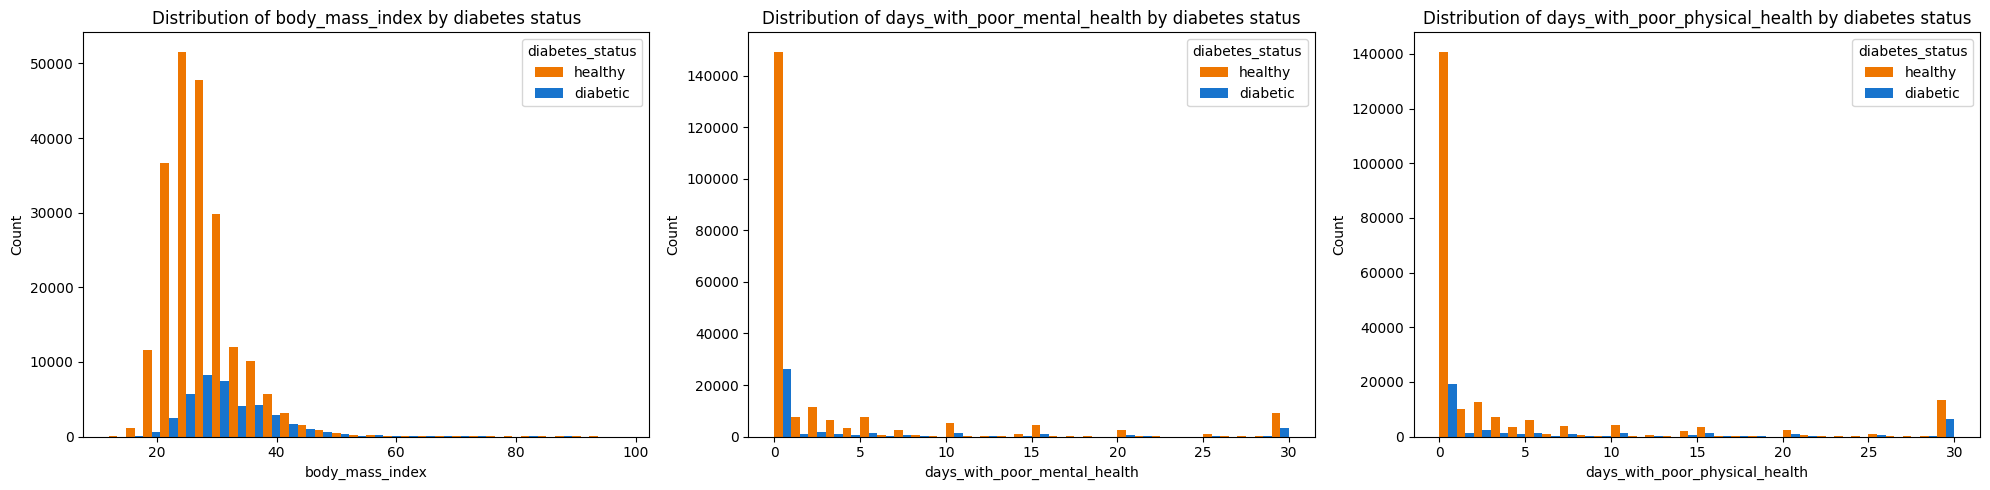

In [29]:
# Select only columns with integer type (non-binary)
numerical_columns = [
    "body_mass_index",
    "days_with_poor_mental_health",
    "days_with_poor_physical_health"
]

# Define layout
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

# Consistent class order and colors
hue_order = ["healthy", "diabetic"]
palette = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

hist_alpha = 1

# Plot histograms stratified by diabetes status
for i, col in enumerate(numerical_columns):
    sns.histplot(
        data=df,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        multiple="dodge",
        bins=30,
        palette=palette,
        alpha=hist_alpha,
        edgecolor=None,
        ax=axes[i]
    )

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Distribution of {col} by diabetes status")

plt.tight_layout()
plt.show()

Given the strong zero-inflation in mental and physical health days,
histograms excluding zero values are shown to better visualize the
distribution among individuals reporting at least one affected day.

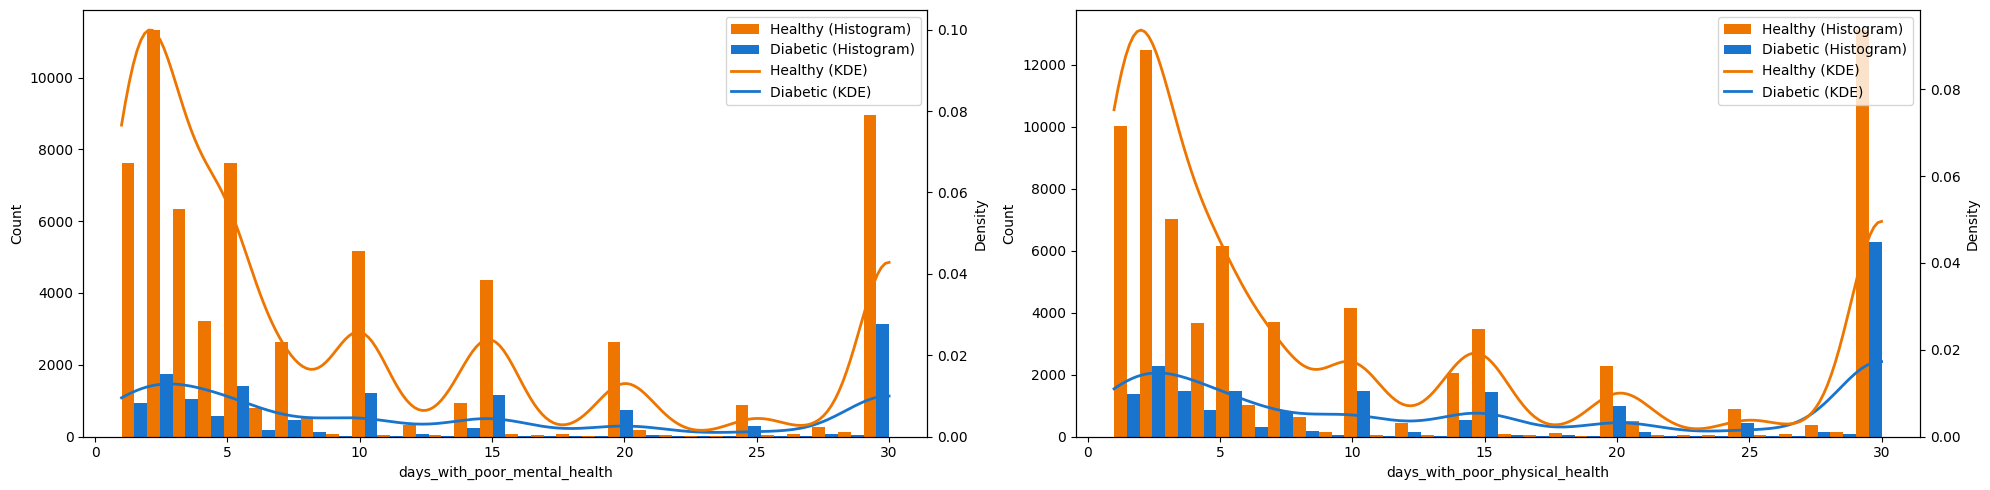

In [28]:
# Columns to plot (exclude zeros)
non_zero_cols = [
    "days_with_poor_mental_health",
    "days_with_poor_physical_health"
]

hue_order = ["healthy", "diabetic"]
palette = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

hist_alpha = 1.0
kde_alpha = 1.0

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes = axes.flatten()

for i, col in enumerate(non_zero_cols):
    data = df[df[col] > 0]

    # Histogram (counts)
    sns.histplot(
        data=data,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        multiple="dodge",
        bins=30,
        palette=palette,
        alpha=hist_alpha,
        edgecolor=None,
        ax=axes[i]
    )

    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

    # KDE (density) on secondary axis
    ax2 = axes[i].twinx()

    sns.kdeplot(
        data=data,
        x=col,
        hue="diabetes_status",
        hue_order=hue_order,
        palette=palette,
        linewidth=2,
        alpha=kde_alpha,
        clip=(1, 30),
        ax=ax2,
        legend=False
    )

    ax2.set_ylabel("Density")


    legend_elements = [
        Patch(facecolor=palette["healthy"], alpha=hist_alpha, label="Healthy (Histogram)"),
        Patch(facecolor=palette["diabetic"], alpha=hist_alpha, label="Diabetic (Histogram)"),
        Line2D([0], [0], color=palette["healthy"], lw=2, alpha=kde_alpha, label="Healthy (KDE)"),
        Line2D([0], [0], color=palette["diabetic"], lw=2, alpha=kde_alpha, label="Diabetic (KDE)")
    ]

    axes[i].legend(handles=legend_elements, loc="upper right")

plt.tight_layout()
plt.show()

Extreme values were identified for body mass index (BMI < 15 and BMI > 60). However, the overall shape of the BMI distribution is broadly similar for diabetic and non-diabetic individuals, with no clear separation toward higher BMI values among the diabetic group at the marginal level. This suggests that, in this dataset, BMI alone does not strongly discriminate diabetes status. This pattern may partially reflect the fact that BMI is a derived variable based on self-reported height and weight, which are subject to measurement error and reporting bias in large population surveys.

For self-reported mental and physical health measures, a substantial proportion of respondents reported high numbers of affected days (up to 30 out of 30), with a marked concentration at round values (e.g., 5, 10, 15, 30 days). This heaping pattern is observed in both diabetic and non-diabetic individuals and is likely consistent with response heaping (anchoring), a well-described effect in self-reported count data, rather than data entry errors. While extreme BMI values likely represent rare but plausible observations, the clustering observed in mental and physical health reflects structural characteristics of the measurement process. As both phenomena involve a non-negligible fraction of the sample and do not provide sufficient evidence of data corruption, all observations were retained for downstream analyses.

<font color="#00868B" size = "3"><b>Visualizing data from non-numerical columns</b></font>

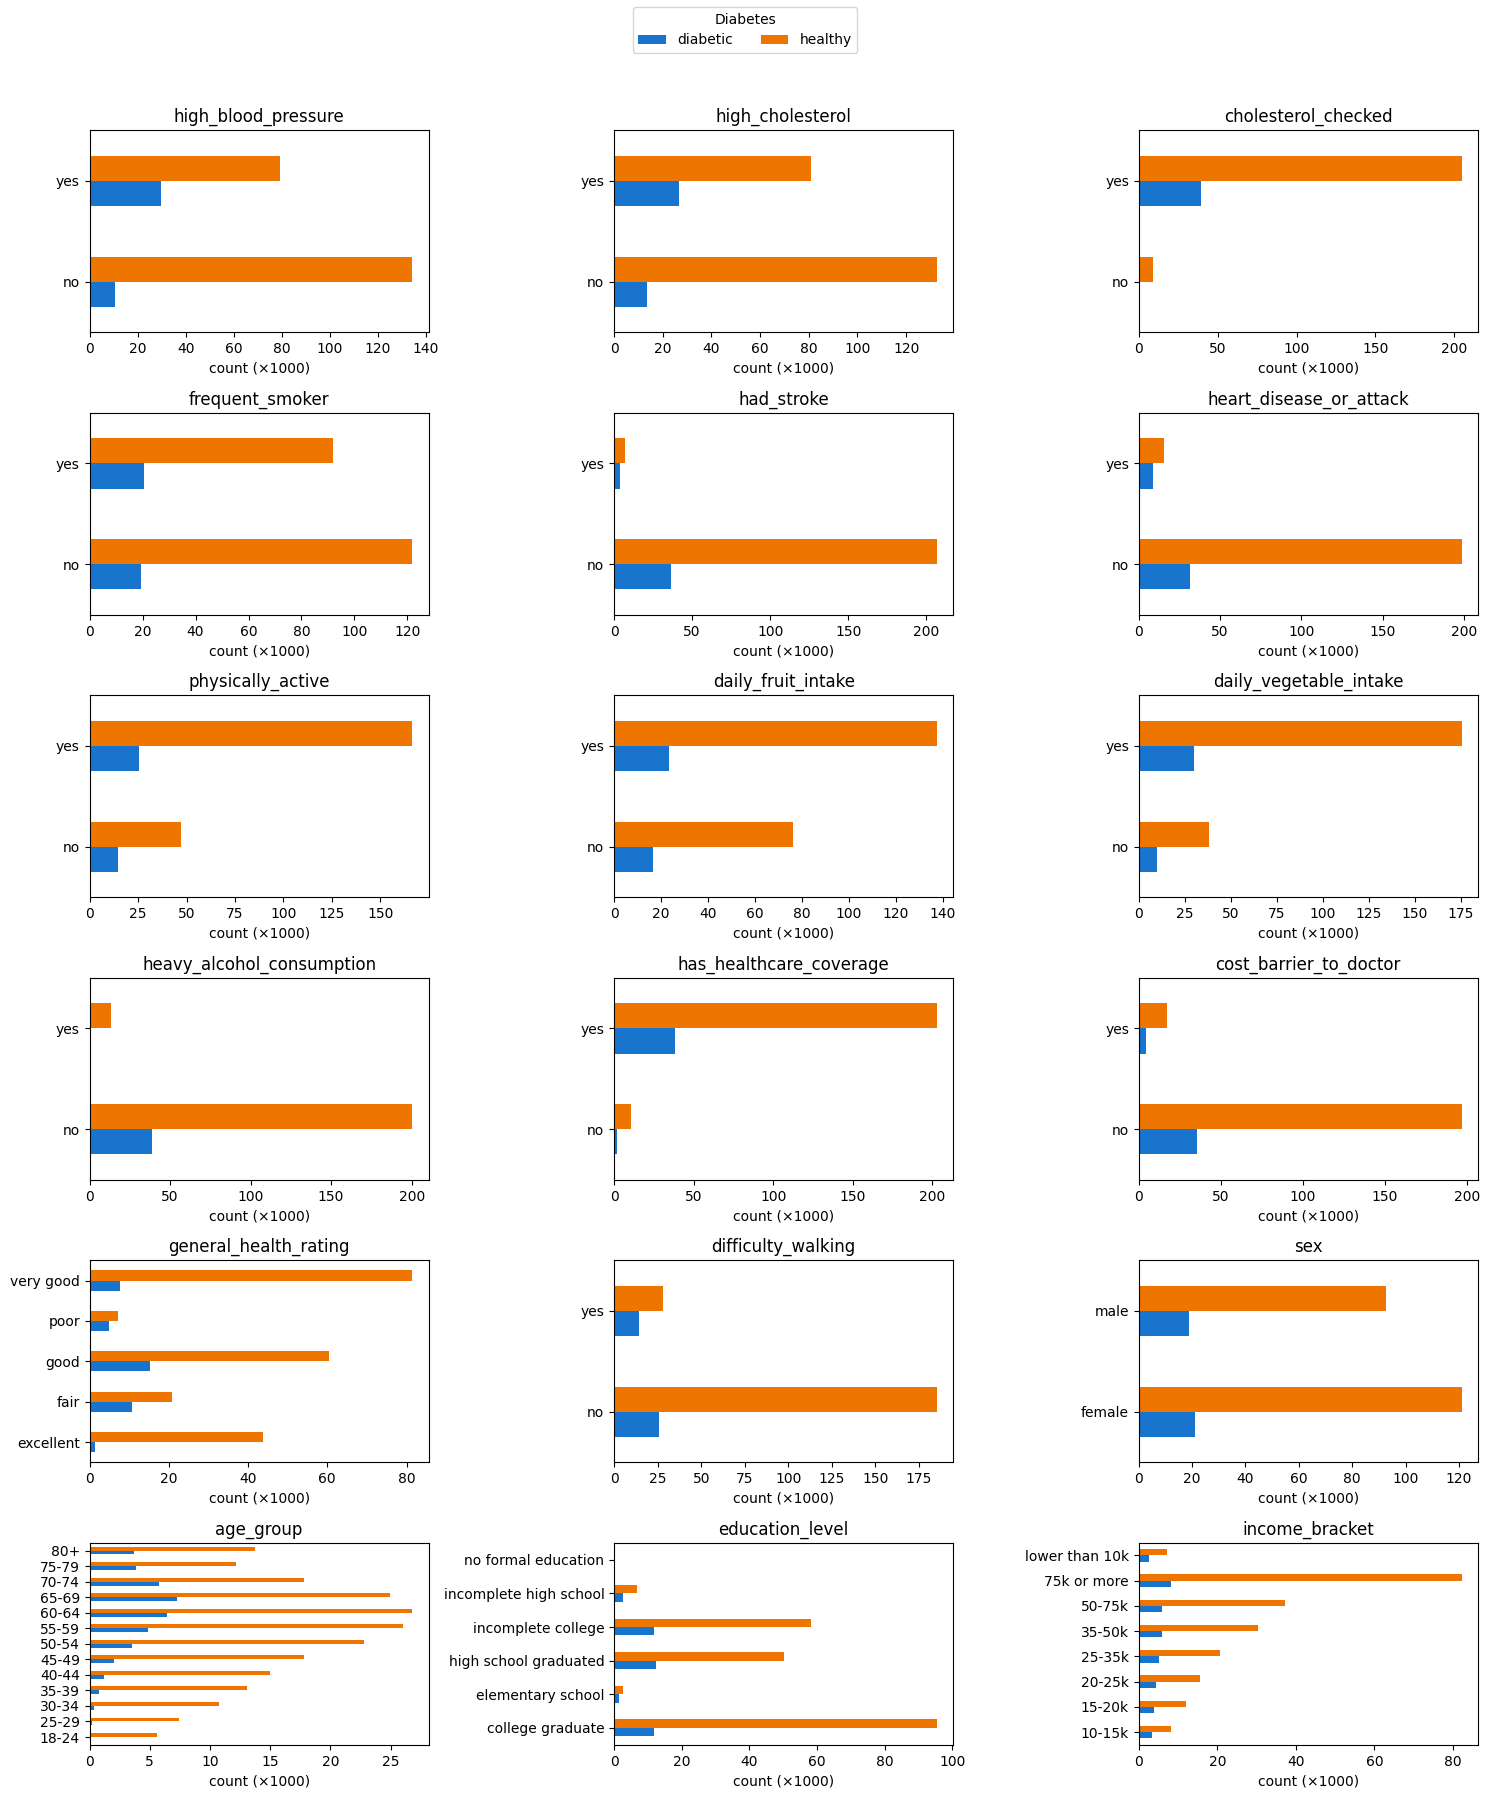

In [25]:
categorical_columns = [
    col for col in df.columns
    if col != "diabetes_status"
    and df[col].dtype == "category"
]

n_cols = 3
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 5, n_rows * 3)
)
axes = axes.flatten()

scale = 1000

color_map = {
    "healthy": "#EE7600",
    "diabetic": "#1874CD"
}

for i, col in enumerate(categorical_columns):
    ct = pd.crosstab(df[col], df["diabetes_status"])
    ct_scaled = ct / scale

    colors = [color_map[c] for c in ct_scaled.columns]

    ct_scaled.plot(
        kind="barh",
        ax=axes[i],
        legend=False,
        color=colors
    )

    axes[i].set_title(col)
    axes[i].set_xlabel(f"count (×{scale})")
    axes[i].set_ylabel("")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Diabetes",
    loc="upper center",
    ncol=2
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Visual inspection of categorical variables reveals consistent and biologically plausible differences between diabetic and non-diabetic individuals. Diabetes shows a clear association with cardiometabolic comorbidities, including a higher prevalence of hypertension and hypercholesterolemia. Compared to healthy individuals, diabetic participants report worse self-perceived health status and a higher frequency of mobility limitations. In addition, diabetes prevalence increases progressively with age. Overall, these patterns are coherent with established epidemiological evidence and support the validity of the dataset for exploratory analysis and downstream predictive modeling.

#Model training and evaluation

Two supervised classification models were selected for this analysis: logistic regression as an interpretable baseline, and CatBoost as a gradient boosting model well suited for datasets with a high proportion of categorical variables.

This approach allows assessing whether increasing model complexity leads to meaningful performance improvements while maintaining a clear comparison framework.

The problem is framed as a risk screening task rather than a diagnostic tool. Consequently, model evaluation focuses on recall for the diabetic class and ROC-AUC, prioritizing the identification of at-risk individuals over minimizing false positives.

<font color="#00868B" size = "3"><b>Model 1: Logistic regression</b></font>

In [30]:
# Define X and y variables
X = df.drop(columns="diabetes_status")
y = df["diabetes_status"]

# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [31]:
# OneHotEncoding of categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), numerical_columns)
    ]
)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded  = preprocessor.transform(X_test)

In [ ]:
#Check correct encoding for a single data sample
feature_names = preprocessor.get_feature_names_out()

idx = X_train.index[0]

original_row = X_train.loc[idx].to_frame(name="original_value")

X_train_encoded_df = pd.DataFrame(
    X_train_encoded.toarray(),
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index
)

encoded_row = X_train_encoded_df.loc[idx].to_frame(name="encoded_value")

print(original_row)
print("----------------------------------------------------------")
print(encoded_row)

                                  original_value
high_blood_pressure                           no
high_cholesterol                              no
cholesterol_checked                          yes
body_mass_index                               23
frequent_smoker                               no
had_stroke                                    no
heart_disease_or_attack                       no
physically_active                            yes
daily_fruit_intake                           yes
daily_vegetable_intake                        no
heavy_alcohol_consumption                     no
has_healthcare_coverage                      yes
cost_barrier_to_doctor                        no
general_health_rating                  excellent
days_with_poor_mental_health                   0
days_with_poor_physical_health                 0
difficulty_walking                            no
sex                                         male
age_group                                  40-44
education_level     

In [ ]:
# Initialize Logistic regression and grid search CV
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")

param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['l2', None], 'C': [0.01, 0.1, 1, 10]},
    {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10], 'l1_ratio':[0.5]}
]

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Model training
grid_search.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2', None],
                          'solver': ['saga']},
                         {'C': [0.01, 0.1, 1, 10], 'l1_ratio': [0.5],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=1)

In [ ]:
# Display the best hyperparameters found by the grid search
print("Best hyperparameters:")
print(grid_search.best_params_)

# Display model performance metrics
y_pred = grid_search.predict(X_test_encoded)
print("\nClassification report:")
print(classification_report(y_test, y_pred))

y_pred_prob = grid_search.predict_proba(X_test_encoded)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

Best hyperparameters:
{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

Classification report:
              precision    recall  f1-score   support

    diabetic       0.34      0.77      0.47      7995
     healthy       0.94      0.72      0.81     42741

    accuracy                           0.72     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.72      0.76     50736

ROC-AUC: 0.8195923527284688


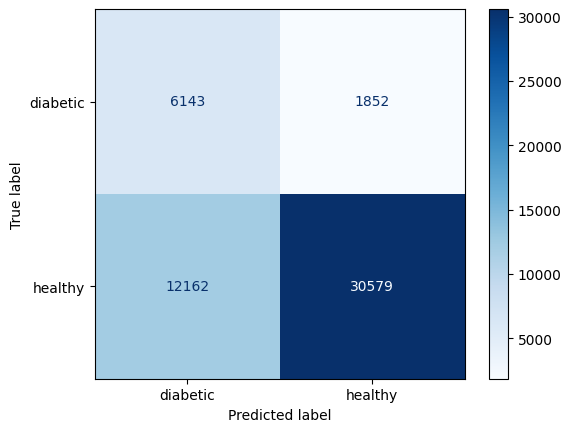

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['diabetic', 'healthy'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['diabetic','healthy'])
disp.plot(cmap='Blues')

In [ ]:
# Feature importance
best_model = grid_search.best_estimator_
feature_names = preprocessor.get_feature_names_out()
coefs = best_model.coef_[0]

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
})

feat_imp = feat_imp.sort_values(by='abs_coefficient', ascending=False)
print(feat_imp)

                                        feature  coefficient  abs_coefficient
27                         cat__age_group_70-74    -1.924402         1.924402
14              cat__general_health_rating_poor    -1.903160         1.903160
28                         cat__age_group_75-79    -1.848834         1.848834
26                         cat__age_group_65-69    -1.824929         1.824929
12              cat__general_health_rating_fair    -1.785810         1.785810
29                           cat__age_group_80+    -1.739457         1.739457
25                         cat__age_group_60-64    -1.633913         1.633913
24                         cat__age_group_55-59    -1.405893         1.405893
13              cat__general_health_rating_good    -1.368693         1.368693
23                         cat__age_group_50-54    -1.309479         1.309479
2                  cat__cholesterol_checked_yes    -1.174271         1.174271
22                         cat__age_group_45-49    -1.085124    

<font color="#8B008B" size = "3"><b>Logistic Regression Results and Interpretation</b></font>

Logistic regression was used as an interpretable baseline model. After hyperparameter tuning with cross-validation and class weighting to address class imbalance, the model achieved a ROC-AUC of ~0.82, indicating good discriminative performance.

The model favors recall for the diabetic class (≈ 0.77), reducing false negatives at the cost of a higher number of false positives. This behavior is appropriate for a screening-oriented use case, where missing true diabetic cases is more costly than incorrectly flagging healthy individuals for further testing.

To improve interpretability, model coefficients were analyzed and ranked by absolute magnitude. The most influential features were primarily related to older age groups, self-reported general health status, and known clinical risk factors, supporting the use of logistic regression as a transparent and well-aligned baseline model.

<font color="#00868B" size = "3"><b>Model 2: CatBoost</b></font>

In [ ]:
# Define X and y variables adapted this time to CatBoost requirements
X_CB = df.drop(columns="diabetes_status")
y_CB = df["diabetes_status"].map({
    "healthy": 0,
    "diabetic": 1
})

# Split data in train and test
X_train_CB, X_test_CB, y_train_CB, y_test_CB = train_test_split(
    X_CB,
    y_CB,
    test_size=0.2,
    random_state=42,
    stratify=y_CB
)

# Obtain index from categorical features
cat_features_idx = [X_CB.columns.get_loc(col) for col in categorical_columns]

# Define training pool
train_pool = Pool(X_train_CB, y_train_CB, cat_features=cat_features_idx)

# Grid
param_grid_CB = {
    "depth": [4, 6, 8],
    "learning_rate": [0.03, 0.1],
    "iterations": [150, 300],
    "l2_leaf_reg": [4, 7],
}

# Initialize CatBoost classifier and grid search CV
CB = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=[1, (y_train_CB == 0).sum() / (y_train_CB == 1).sum()],
    random_seed=42,
    verbose=0
)


grid_search_CB = GridSearchCV(
    CB,
    param_grid_CB,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Model training
grid_search_CB.fit(X_train_CB, y_train_CB, cat_features=cat_features_idx)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x79ff5717c3b0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [150, 300],
                         'l2_leaf_reg': [4, 7], 'learning_rate': [0.03, 0.1]},
             scoring='roc_auc', verbose=1)

Best hyperparameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.1}

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.81     42741
           1       0.34      0.79      0.47      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.75      0.64     50736
weighted avg       0.85      0.72      0.76     50736

ROC-AUC: 0.8257137691591158


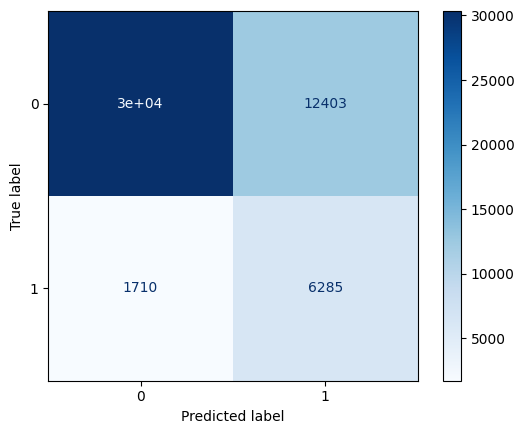

In [ ]:
# Metrics
best_CB = grid_search_CB.best_estimator_
print("Best hyperparameters:", grid_search_CB.best_params_)

y_pred_CB = best_CB.predict(X_test_CB)
y_pred_prob_CB = best_CB.predict_proba(X_test_CB)[:,1]

print("\nClassification report:")
print(classification_report(y_test_CB, y_pred_CB))

roc_auc = roc_auc_score(y_test_CB, y_pred_prob_CB)
print("ROC-AUC:", roc_auc)

cm = confusion_matrix(y_test_CB, y_pred_CB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [ ]:
# Feature importance
feat_imp_CB_df = pd.DataFrame({
    'feature': best_CB.feature_names_,
    'importance': best_CB.get_feature_importance()
}).sort_values(by='importance', ascending=False)

print(feat_imp_CB_df)

                           feature  importance
13           general_health_rating   25.636097
18                       age_group   19.070746
3                  body_mass_index   16.621365
0              high_blood_pressure   13.762088
1                 high_cholesterol    7.405229
2              cholesterol_checked    4.906932
20                  income_bracket    3.556516
17                             sex    1.916881
10       heavy_alcohol_consumption    1.582007
16              difficulty_walking    1.305499
6          heart_disease_or_attack    1.124765
19                 education_level    0.872783
14    days_with_poor_mental_health    0.666975
15  days_with_poor_physical_health    0.464464
4                  frequent_smoker    0.277668
7                physically_active    0.213795
8               daily_fruit_intake    0.190415
5                       had_stroke    0.152820
9           daily_vegetable_intake    0.130586
11         has_healthcare_coverage    0.094239
12          c

<font color="#8B008B" size = "3"><b>CatBoost — Results and Interpretation</b></font>

CatBoost achieved a ROC-AUC of ~0.826, slightly outperforming logistic regression in overall discriminative ability. At the default classification threshold, the model showed a higher recall for the diabetic class (≈ 0.79), reducing the number of false negatives compared to the logistic regression baseline, while maintaining similar overall accuracy.

This improvement comes at the cost of a comparable number of false positives, indicating that CatBoost shifts the decision boundary toward greater sensitivity rather than improving precision. Feature importance analysis highlights general health rating, age group, body mass index, and cardiovascular risk factors as the most influential variables, consistent with both domain knowledge and the patterns observed in the linear model.

Overall, CatBoost captures limited non-linear structure beyond what is already learned by logistic regression, resulting in a modest but measurable reduction in missed diabetic cases.

<font color="#00868B" size = "3"><b>Model Comparison and Use-Case Recommendation</b></font>

Both models show similar overall performance, suggesting that the dataset’s predictive structure is largely linear. Logistic regression provides strong baseline performance with high interpretability, robustness, and ease of deployment, making it well suited for scenarios where transparency and simplicity are prioritized.

CatBoost offers a small but consistent improvement in recall for the diabetic class, reducing false negatives in comparison to logistic regression. This behavior is advantageous in screening-oriented use cases, where the primary objective is to identify as many at-risk individuals as possible, even at the expense of additional false positives that can be addressed through follow-up testing.

Considering the characteristics of the dataset and the modest performance gains observed, logistic regression emerges as the recommended model for this application. Its transparency, stability, and ease of interpretation make it better aligned with real-world deployment in health screening contexts based on self-reported survey data.

In a screening setting, model behavior could be further adapted by adjusting the classification threshold to prioritize sensitivity for the diabetic class, depending on operational constraints and downstream capacity. Such calibration would allow balancing recall and false positives without requiring model retraining.

Taken together, these results highlight the trade-off between interpretability and sensitivity in medical risk screening models, while supporting logistic regression as the preferred default approach for this dataset.